In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
np.set_printoptions(precision=5)#show 5 number after decimal point 

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
print("X_train.shape :" ,X_train.shape)
print("y_train.shape :", y_train.shape)
print ("X_test.shape :" , X_test.shape)
print("y_test.shape :", y_test.shape)

X_train.shape : (60000, 28, 28)
y_train.shape : (60000,)
X_test.shape : (10000, 28, 28)
y_test.shape : (10000,)


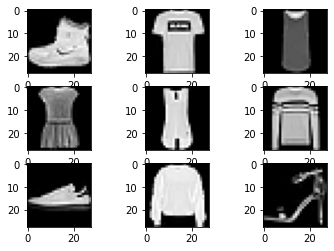

In [5]:
for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
X_train = X_train.reshape(60000,28*28)
X_test = X_test.reshape(10000, 28*28)

In [8]:
print("X_train.shape :" ,X_train.shape)
print("y_train.shape :", y_train.shape)
print ("X_test.shape :" , X_test.shape)
print("y_test.shape :", y_test.shape)

X_train.shape : (60000, 784)
y_train.shape : (60000,)
X_test.shape : (10000, 784)
y_test.shape : (10000,)


In [9]:
#Check that we have balnced data
unique, counts = np.unique(y_train, return_counts=True)
print("y_train :", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("y_test :", dict(zip(unique, counts)))

y_train : {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
y_test : {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


##  *Models:*

We will try several models and in the end we will decide which is the best model.<br>
We will try the following models:
* Random Forest
* KNN

In [10]:
#split the train
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

In [11]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train1, y_train1)
y_pred = dummy_clf.predict(X_val1)
print("The DummyClassifier score is:" ,round(accuracy_score(y_pred,y_val1),2))

The DummyClassifier score is: 0.09


### *Feature selection:*

In [17]:
scores = []
for i in range(250,360,20):
    X_new = SelectKBest(chi2, k=i).fit_transform(X_train1, y_train1)
    X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_new,y_train1, test_size=0.1, random_state=42)
    KNN = KNeighborsClassifier().fit(X_train_new, y_train_new)
    y_pred = KNN.predict(X_val_new)
    accuracy = round(metrics.accuracy_score(y_val_new, y_pred),3)
    print("number of features : ", i, ", Accuracy:", accuracy)
    scores.append(accuracy)

number of features :  250 , Accuracy: 0.842
number of features :  270 , Accuracy: 0.841
number of features :  290 , Accuracy: 0.843
number of features :  310 , Accuracy: 0.845
number of features :  330 , Accuracy: 0.848
number of features :  350 , Accuracy: 0.85


In [52]:
### best accuracy with 350 features.

In [12]:
X_train = SelectKBest(chi2, k=350).fit_transform(X_train1, y_train1)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train1, test_size=0.1, random_state=42)

### *KNN :*

In [13]:
KNN = KNeighborsClassifier().fit(X_train, y_train)
y_predict = KNN.predict(X_val)
accuracy = metrics.accuracy_score(y_val, y_predict)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.85


### *Random Forest Classifier:*

In [14]:
RF = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = RF.predict(X_val)
accuracy = metrics.accuracy_score(y_val, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.87



### *XGBoost:*

In [15]:
%%time

XGB = XGBClassifier(objective="multi:softprob",num_class=10).fit(X_train, y_train,eval_metric='auc')
y_pred = XGB.predict(X_val)      
accuracy = metrics.accuracy_score(y_val, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.891
CPU times: total: 20min 15s
Wall time: 3min


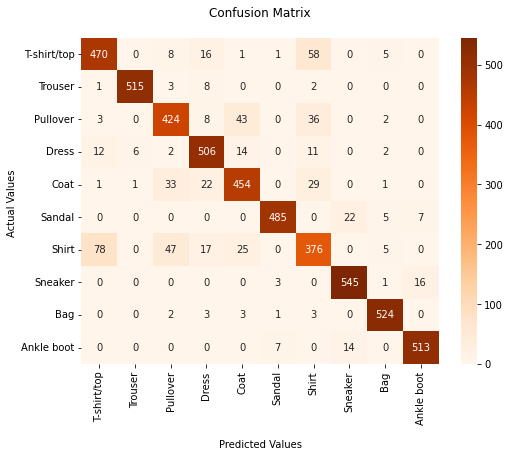

In [16]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
cf_matrix = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Oranges')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(labels,rotation=90)
ax.yaxis.set_ticklabels(labels,rotation=0)

plt.show()

### *PCA:*

In [12]:
pca = PCA(n_components = 196)
pca.fit(X_train1)

PCA(n_components=196)

In [13]:
X_reduced_train = pca.transform(X_train1)
X_reduced_test = pca.transform(X_val1)

In [14]:
X_reduced_train.shape

(54000, 196)

Text(0.5, 1.0, 'After PCA')

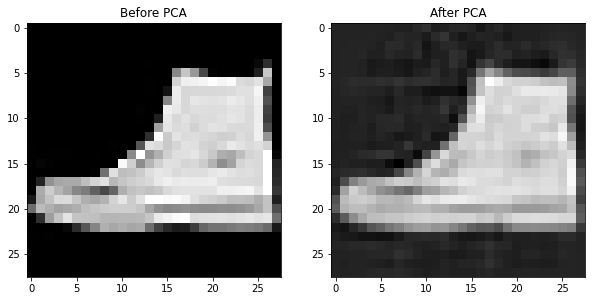

In [15]:
fig = plt.figure(figsize=(10, 7))
X_recovered = pca.inverse_transform(X_reduced_train)
  
fig.add_subplot(1, 2, 1)
plt.imshow(X_train1[2,:].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.title("Before PCA")

fig.add_subplot(1, 2, 2)
plt.imshow(X_recovered[2,:].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.title("After PCA")

### *Logistic Regression with PCA:*

In [21]:
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_reduced_train, y_train1)

LogisticRegression()

In [22]:
y_predict = logisticRegr.predict(X_reduced_test)
accuracy =  metrics.accuracy_score(y_val1,y_predict)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.855


### *Random Forest with PCA:*

In [ ]:
RF = RandomForestClassifier(random_state=42).fit(X_reduced_train, y_train1)
y_predict = RF.predict(X_reduced_test)
accuracy = metrics.accuracy_score(y_val1,y_predict)
print("Accuracy:", round(accuracy,3))

### *XGBoot with PCA:*

In [23]:
%%time
XGB = XGBClassifier(objective="multi:softprob",num_class=10).fit(X_reduced_train, y_train1,eval_metric='auc')
y_pred = XGB.predict(X_reduced_test)
accuracy = metrics.accuracy_score(y_val1, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.884
CPU times: total: 1h 22min 20s
Wall time: 11min 9s


### Randomized Search CV :

In [ ]:
%%time

parameters = {
        'max_depth': [3, 5, 7, 10],
        'n_estimators' : [int(x) for x in range(50, 200,10)],
        'objective': ['multi:softprob']
         }
random_XGB = RandomizedSearchCV(XGBClassifier(num_class=10),parameters, verbose=True, 
                          scoring='accuracy',random_state=42, n_iter = 15)
random_XGB.fit(X_reduced_train,y_train1,eval_metric='auc')
y_pred_XGB_random = random_XGB.predict(X_reduced_test)
accuracy = metrics.accuracy_score(y_val1, y_pred)
print("Accuracy:", round(accuracy,3))

print (random_XGB.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


### Test the full data with the best models

* XGBoost with PCA
* XGBoost without PCA
